# Visualizing Neural Networks with Pure Python / Tutorials

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 1, Tutorials

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to:
- visualize neural networks

The networks have 2 input and 1 output neurons, but arbitrarily many hidden layers, and also you can choose the activation functions

### Imports: only numpy and matplotlib

In [1]:
#from numpy import array, zeros, exp, random, dot, shape, reshape, meshgrid, linspace
import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for nice inset colorbars:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Functions

In [2]:
def apply_layer(y_in,w,b,activation):
    """
    Go from one layer to the next, given a 
    weight matrix w (shape [n_neurons_in,n_neurons_out])
    a bias vector b (length n_neurons_out)
    and the values of input neurons y_in 
    (shape [batchsize,n_neurons_in])
    
    returns the values of the output neurons in the next layer 
    (shape [batchsize, n_neurons_out])
    """
    # to understand the following line, watch the beginning of lecture 2
    z=np.dot(y_in,w)+b # batch processing: y_in is of shape [batchsize,num_neurons_in]
    if activation=='sigmoid':
        return(1/(1+np.exp(-z)))
    elif activation=='jump':
        return(np.array(z>0,dtype='float'))
    elif activation=='linear':
        return(z)
    elif activation=='reLU':
        return((z>0)*z)

def apply_net(y_in,weights,biases,activations):
    """
    Apply a whole network of multiple layers
    """
    y=y_in
    for j in range(len(biases)):
        y=apply_layer(y,weights[j],biases[j],activations[j])
    return(y)

# some internal routines for plotting the network:
def plot_connection_line(ax,X,Y,W,vmax=1.0,linewidth=3):
    t=np.linspace(0,1,20)
    if W>0:
        col=[0,0.4,0.8]
    else:
        col=[1,0.3,0]
    ax.plot(X[0]+(3*t**2-2*t**3)*(X[1]-X[0]),Y[0]+t*(Y[1]-Y[0]),
           alpha=abs(W)/vmax,color=col,
           linewidth=linewidth)
    
def plot_neuron_alpha(ax,X,Y,B,size=100.0,vmax=1.0):
    if B>0:
        col=[0,0.4,0.8]
    else:
        col=[1,0.3,0]
    ax.scatter([X],[Y],marker='o',c=col,alpha=abs(B)/vmax,s=size,zorder=10)

def plot_neuron(ax,X,Y,B,size=100.0,vmax=1.0):
    if B>0:
        col=[0,0.4,0.8]
    else:
        col=[1,0.3,0]
    ax.scatter([X],[Y],marker='o',c=col,s=size,zorder=10)
    
def visualize_network(weights,biases,activations,
                      M=100,y0range=[-1,1],y1range=[-1,1],
                     size=400.0, linewidth=5.0):
    """
    Visualize a neural network with 2 input 
    neurons and 1 output neuron (plot output vs input in a 2D plot)
    
    weights is a list of the weight matrices for the
    layers, where weights[j] is the matrix for the connections
    from layer j to layer j+1 (where j==0 is the input)
    
    weights[j][m,k] is the weight for input neuron k going to output neuron m
    (note: internally, m and k are swapped, see the explanation of
    batch processing in lecture 2)
    
    biases[j] is the vector of bias values for obtaining the neurons in layer j+1
    biases[j][k] is the bias for neuron k in layer j+1
    
    activations is a list of the activation functions for
    the different layers: choose 'linear','sigmoid',
    'jump' (i.e. step-function), and 'reLU'
    
    M is the resolution (MxM grid)
    
    y0range is the range of y0 neuron values (horizontal axis)
    y1range is the range of y1 neuron values (vertical axis)
    """
    swapped_weights=[]
    for j in range(len(weights)):
        swapped_weights.append(np.transpose(weights[j]))
        
    y0,y1=np.meshgrid(np.linspace(y0range[0],y0range[1],M),np.linspace(y1range[0],y1range[1],M))
    y_in=np.zeros([M*M,2])
    y_in[:,0]=y0.flatten()
    y_in[:,1]=y1.flatten()
    y_out=apply_net(y_in,swapped_weights,biases,activations)

    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(8,4))
    
    # plot the network itself:
    
    # positions of neurons on plot:
    posX=[[-0.5,+0.5]]; posY=[[0,0]]
    vmax=0.0 # for finding the maximum weight
    vmaxB=0.0 # for maximum bias
    for j in range(len(biases)):
        n_neurons=len(biases[j])
        posX.append(np.array(range(n_neurons))-0.5*(n_neurons-1))
        posY.append(np.full(n_neurons,j+1))
        vmax=np.maximum(vmax,np.max(np.abs(weights[j])))
        vmaxB=np.maximum(vmaxB,np.max(np.abs(biases[j])))

    # plot connections
    for j in range(len(biases)):
        for k in range(len(posX[j])):
            for m in range(len(posX[j+1])):
                plot_connection_line(ax[0],[posX[j][k],posX[j+1][m]],
                                     [posY[j][k],posY[j+1][m]],
                                     swapped_weights[j][k,m],vmax=vmax,
                                    linewidth=linewidth)
    
    # plot neurons
    for k in range(len(posX[0])): # input neurons (have no bias!)
        plot_neuron(ax[0],posX[0][k],posY[0][k],
                   vmaxB,vmax=vmaxB,size=size)
    for j in range(len(biases)): # all other neurons
        for k in range(len(posX[j+1])):
            plot_neuron(ax[0],posX[j+1][k],posY[j+1][k],
                       biases[j][k],vmax=vmaxB,size=size)
    
    ax[0].axis('off')
    
    # now: the output of the network
    img=ax[1].imshow(np.reshape(y_out,[M,M]),origin='lower',
                    extent=[y0range[0],y0range[1],y1range[0],y1range[1]])
    ax[1].set_xlabel(r'$y_0$')
    ax[1].set_ylabel(r'$y_1$')
    
    axins1 = inset_axes(ax[1],
                    width="40%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='upper right')

    imgmin=np.min(y_out)
    imgmax=np.max(y_out)
    color_bar=fig.colorbar(img, cax=axins1, orientation="horizontal",ticks=np.linspace(imgmin,imgmax,3))
    cbxtick_obj = plt.getp(color_bar.ax.axes, 'xticklabels')
    plt.setp(cbxtick_obj, color="white")
    axins1.xaxis.set_ticks_position("bottom")

    plt.show()

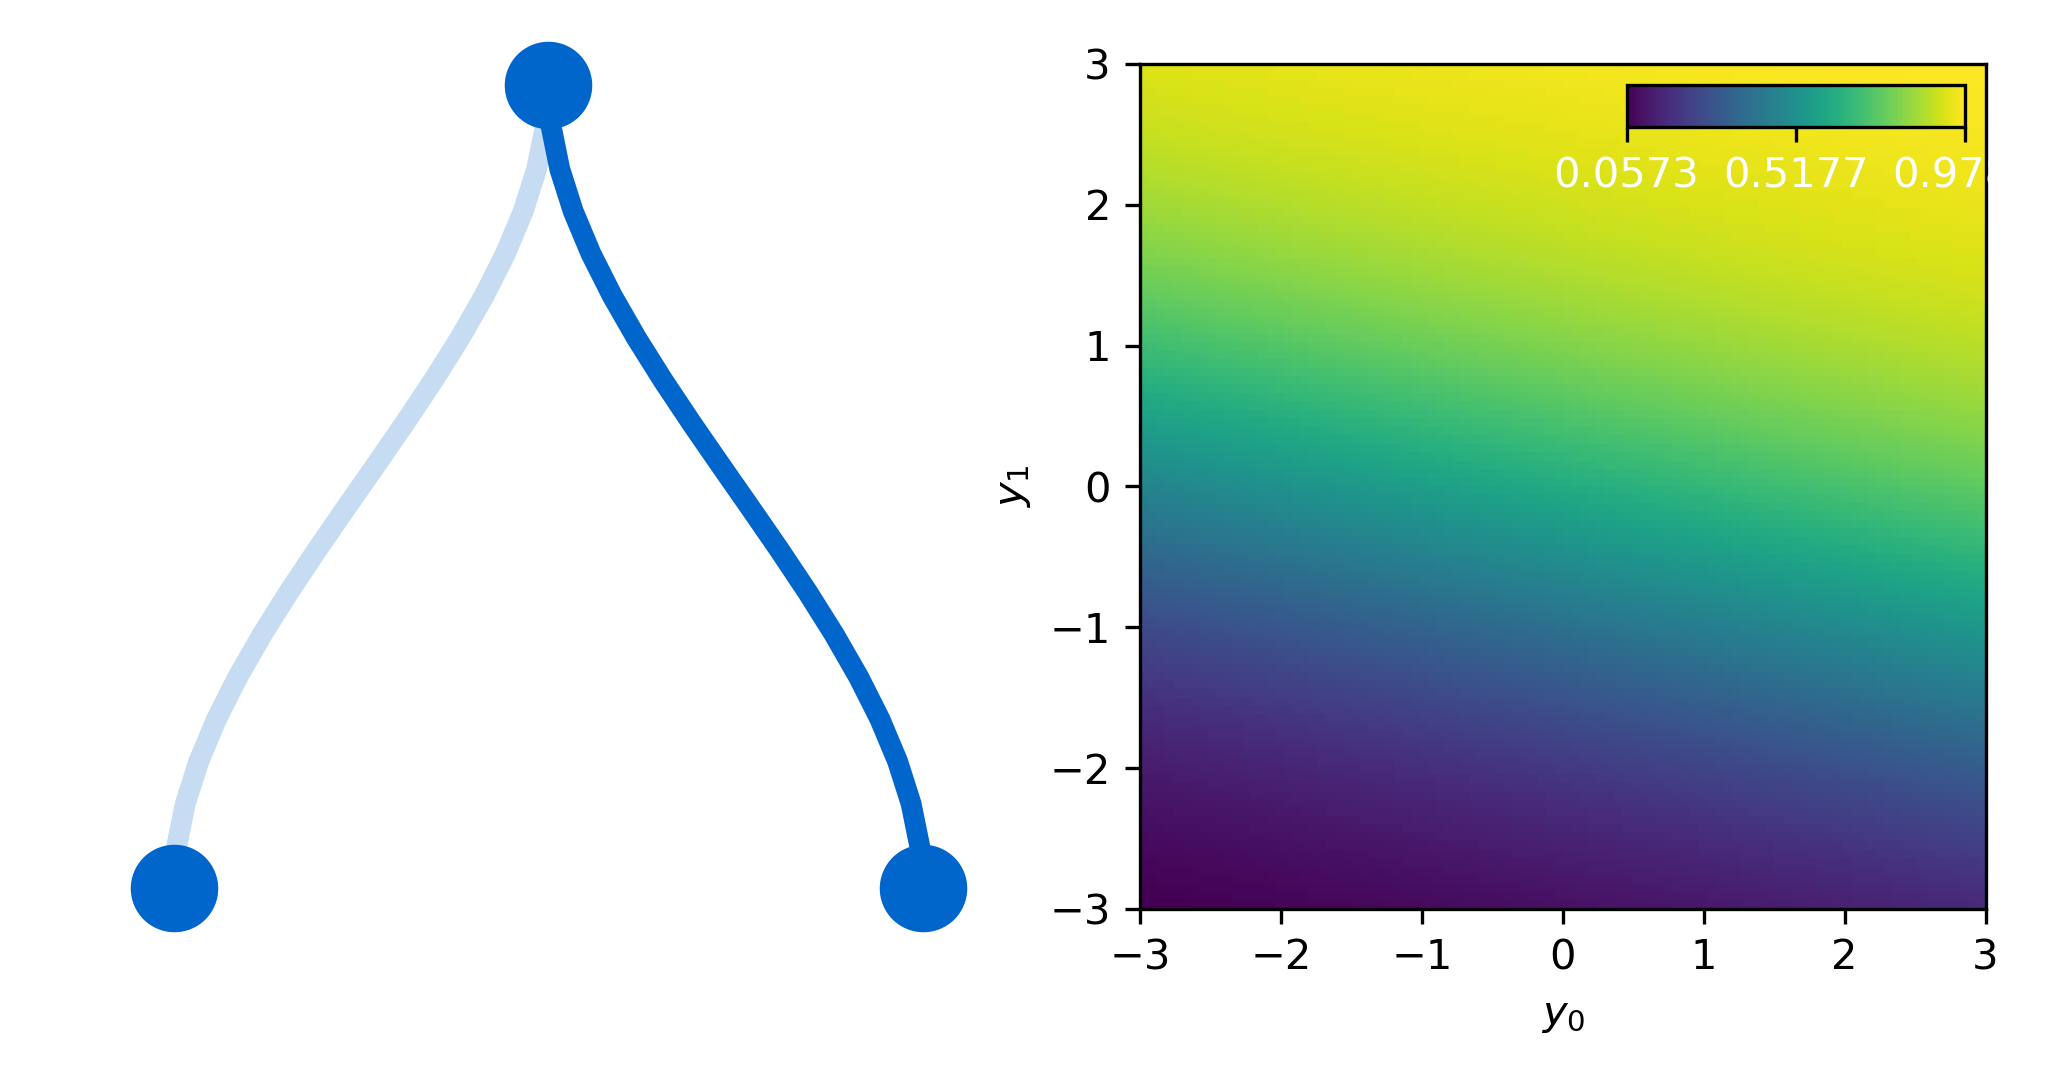

In [6]:
visualize_network(weights=[ [ 
    [0.2,0.9]  # weights of 2 input neurons for single output neuron
    ] ],
    biases=[ 
        [0.5] # bias for single output neuron
            ],
    activations=[ 'sigmoid' # activation for output
                ],
    y0range=[-3,3],y1range=[-3,3])

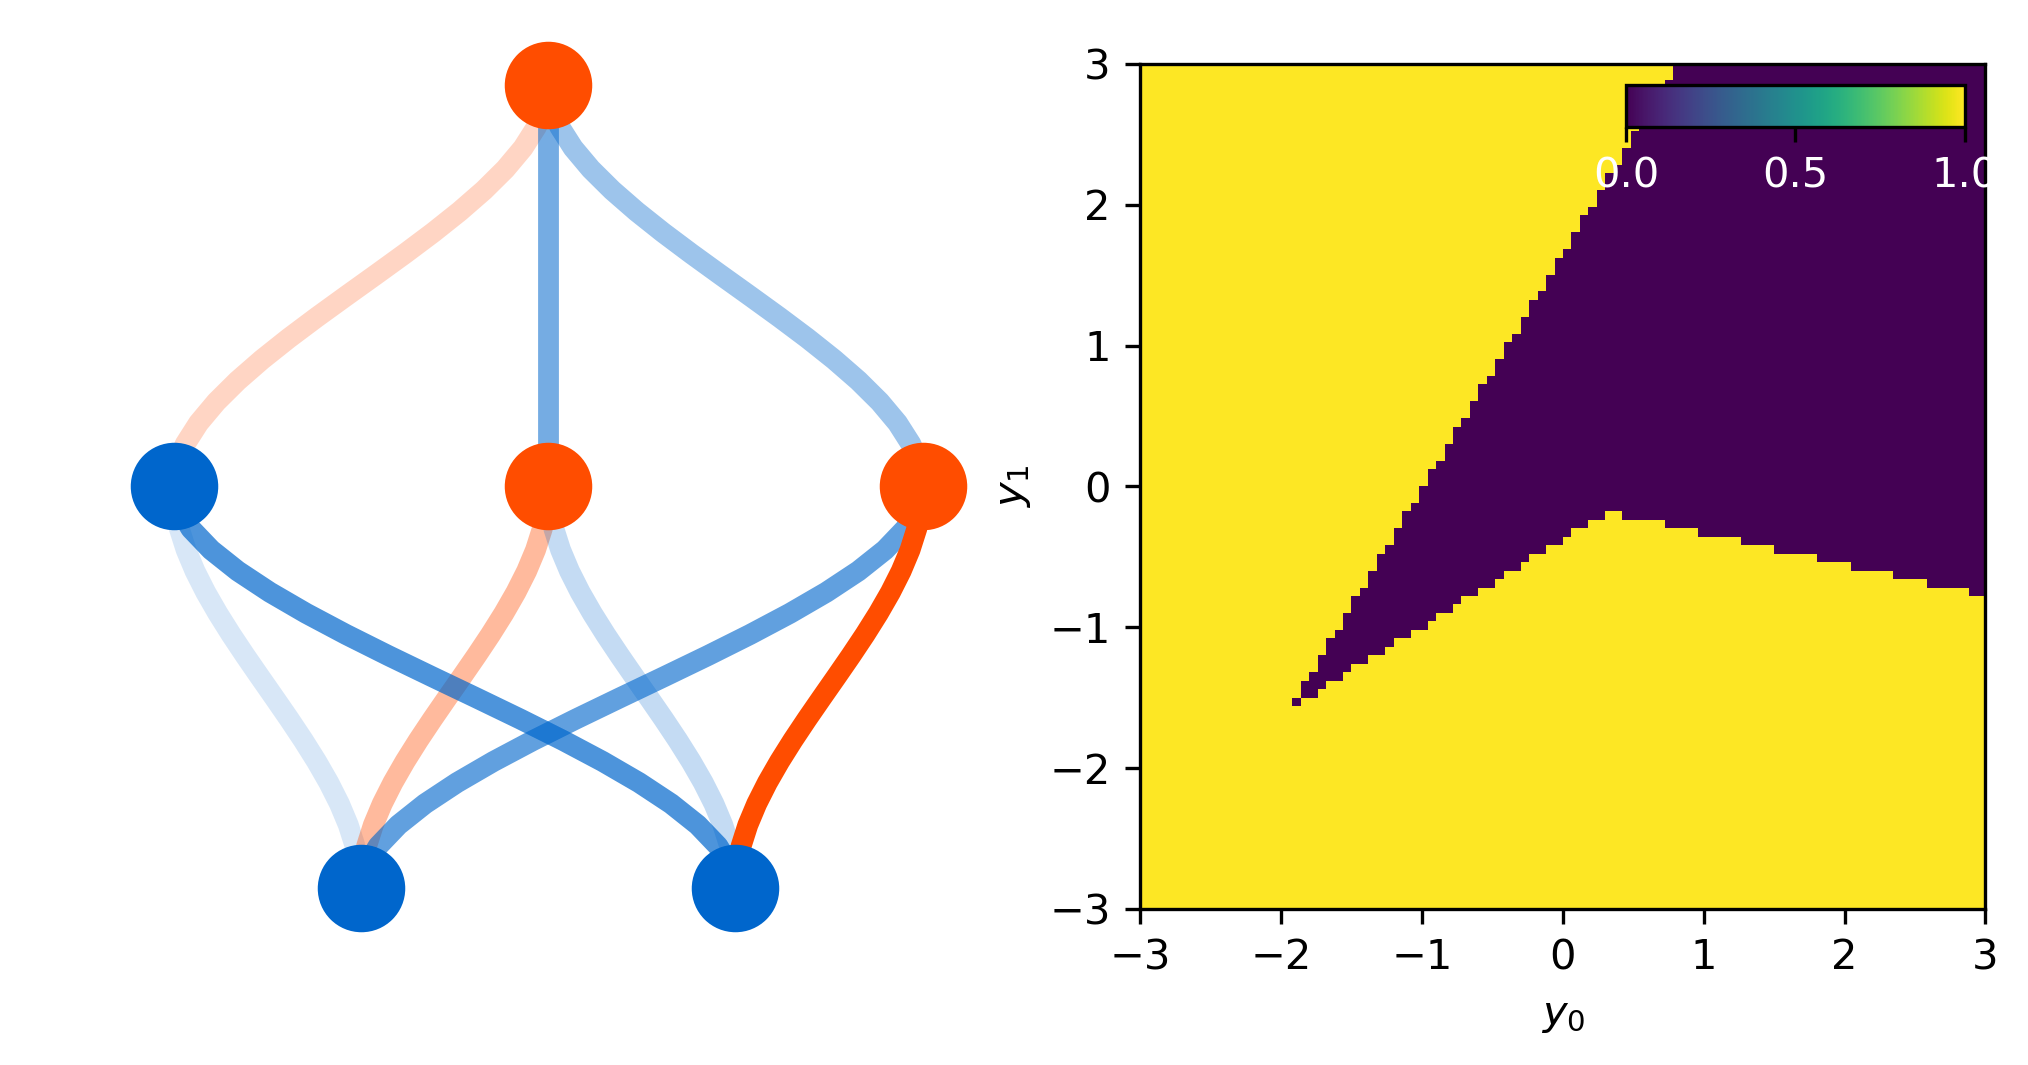

In [9]:
visualize_network(weights=[ [ 
    [0.2,0.9],  # weights of 2 input neurons for 1st hidden neuron
    [-0.5,0.3], # weights of 2 input neurons for 2nd hidden
    [0.8,-1.3]  # weights of 2 input neurons for 3rd hidden
    ],                 
    [ 
        [-0.3,0.7,0.5] # weights of 3 hidden neurons for output
    ]  ],
    biases=[ 
        [0.1,-0.5,-0.5], # biases of 3 hidden neurons
        [-.2] # bias for output neuron
            ],
    activations=[ 'jump', # activation for hidden
                'jump' # activation for output
                ],
    y0range=[-3,3],y1range=[-3,3])

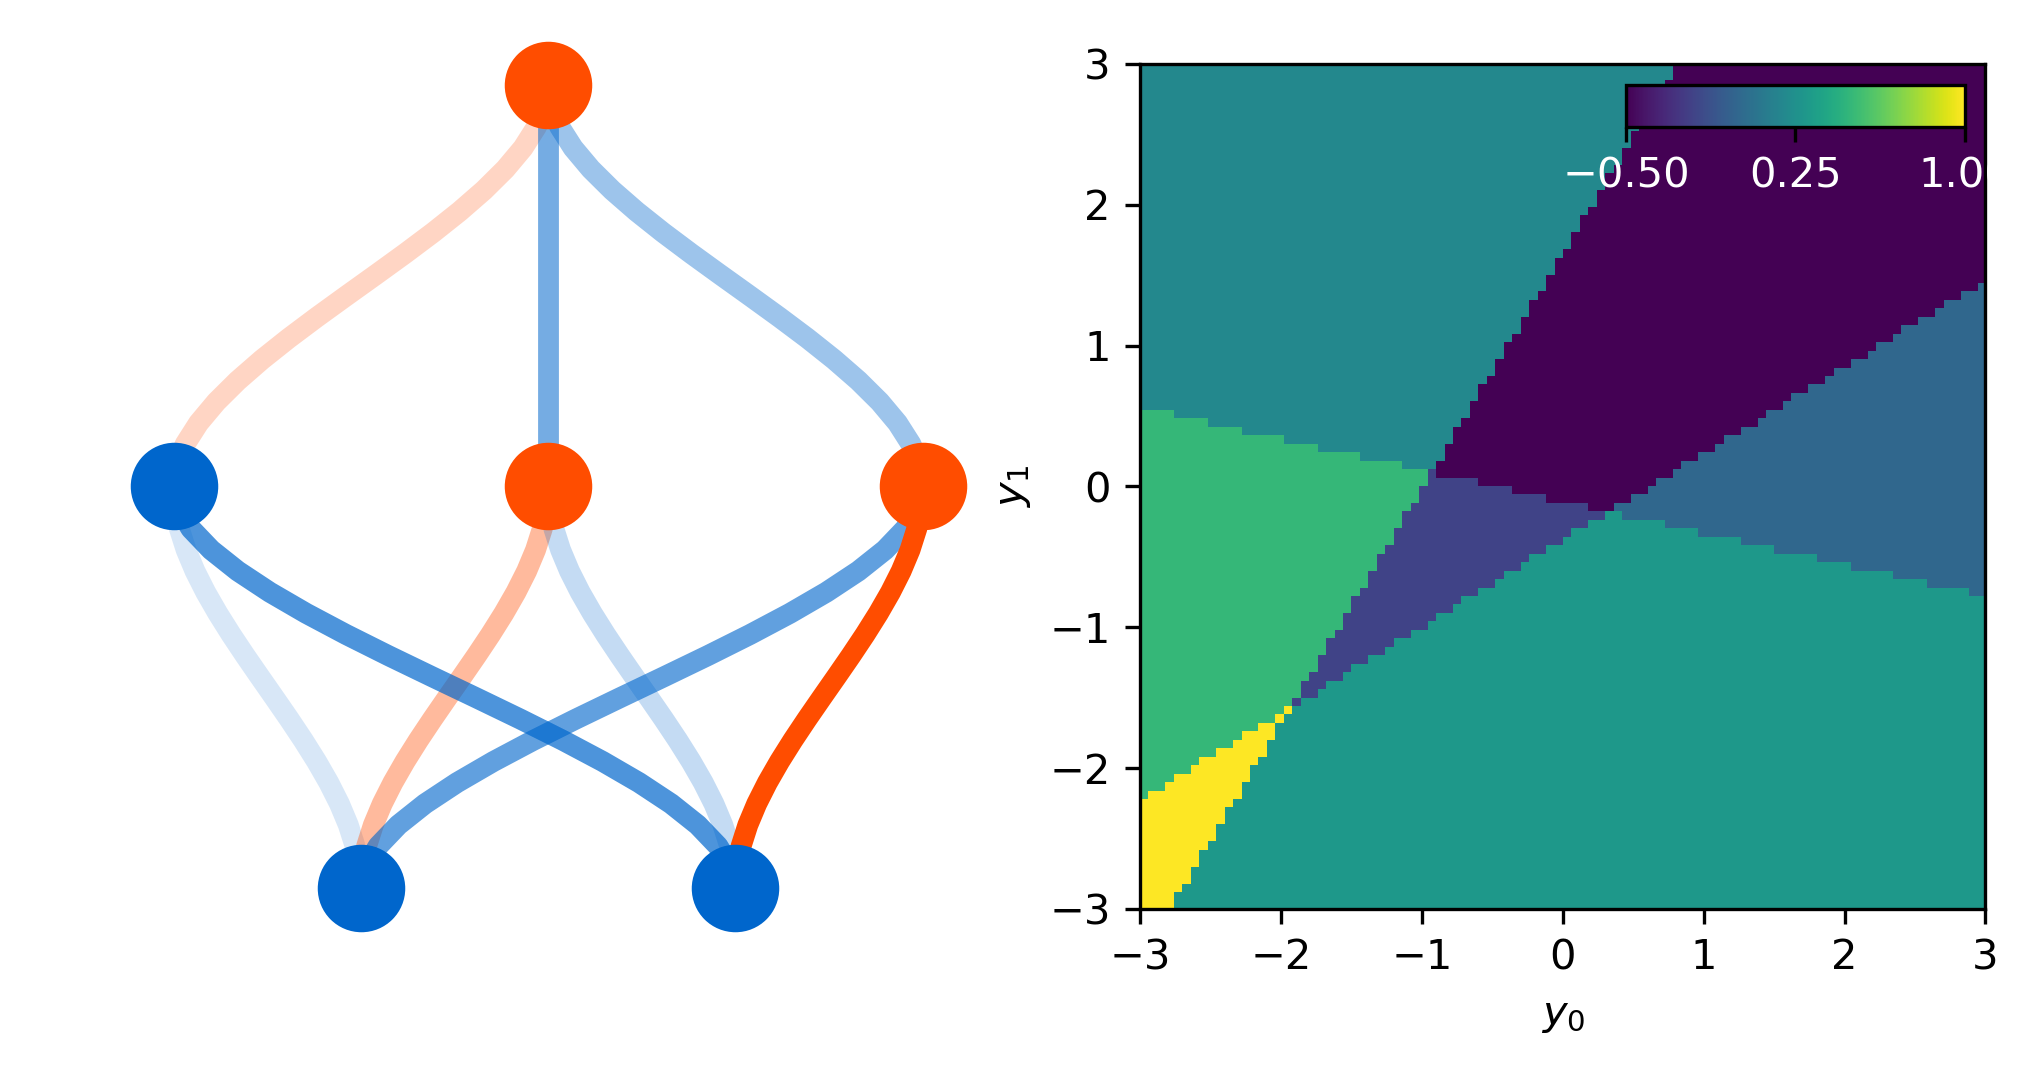

In [5]:
visualize_network(weights=[ [ 
    [0.2,0.9],  # weights of 2 input neurons for 1st hidden neuron
    [-0.5,0.3], # weights of 2 input neurons for 2nd hidden
    [0.8,-1.3]  # weights of 2 input neurons for 3rd hidden
    ],                 
    [ 
        [-0.3,0.7,0.5] # weights of 3 hidden neurons for output
    ]  ],
    biases=[ 
        [0.1,-0.5,-0.5], # biases of 3 hidden neurons
        [-.2] # bias for output neuron
            ],
    activations=[ 'jump', # activation for hidden
                'linear' # activation for output
                ],
    y0range=[-3,3],y1range=[-3,3])

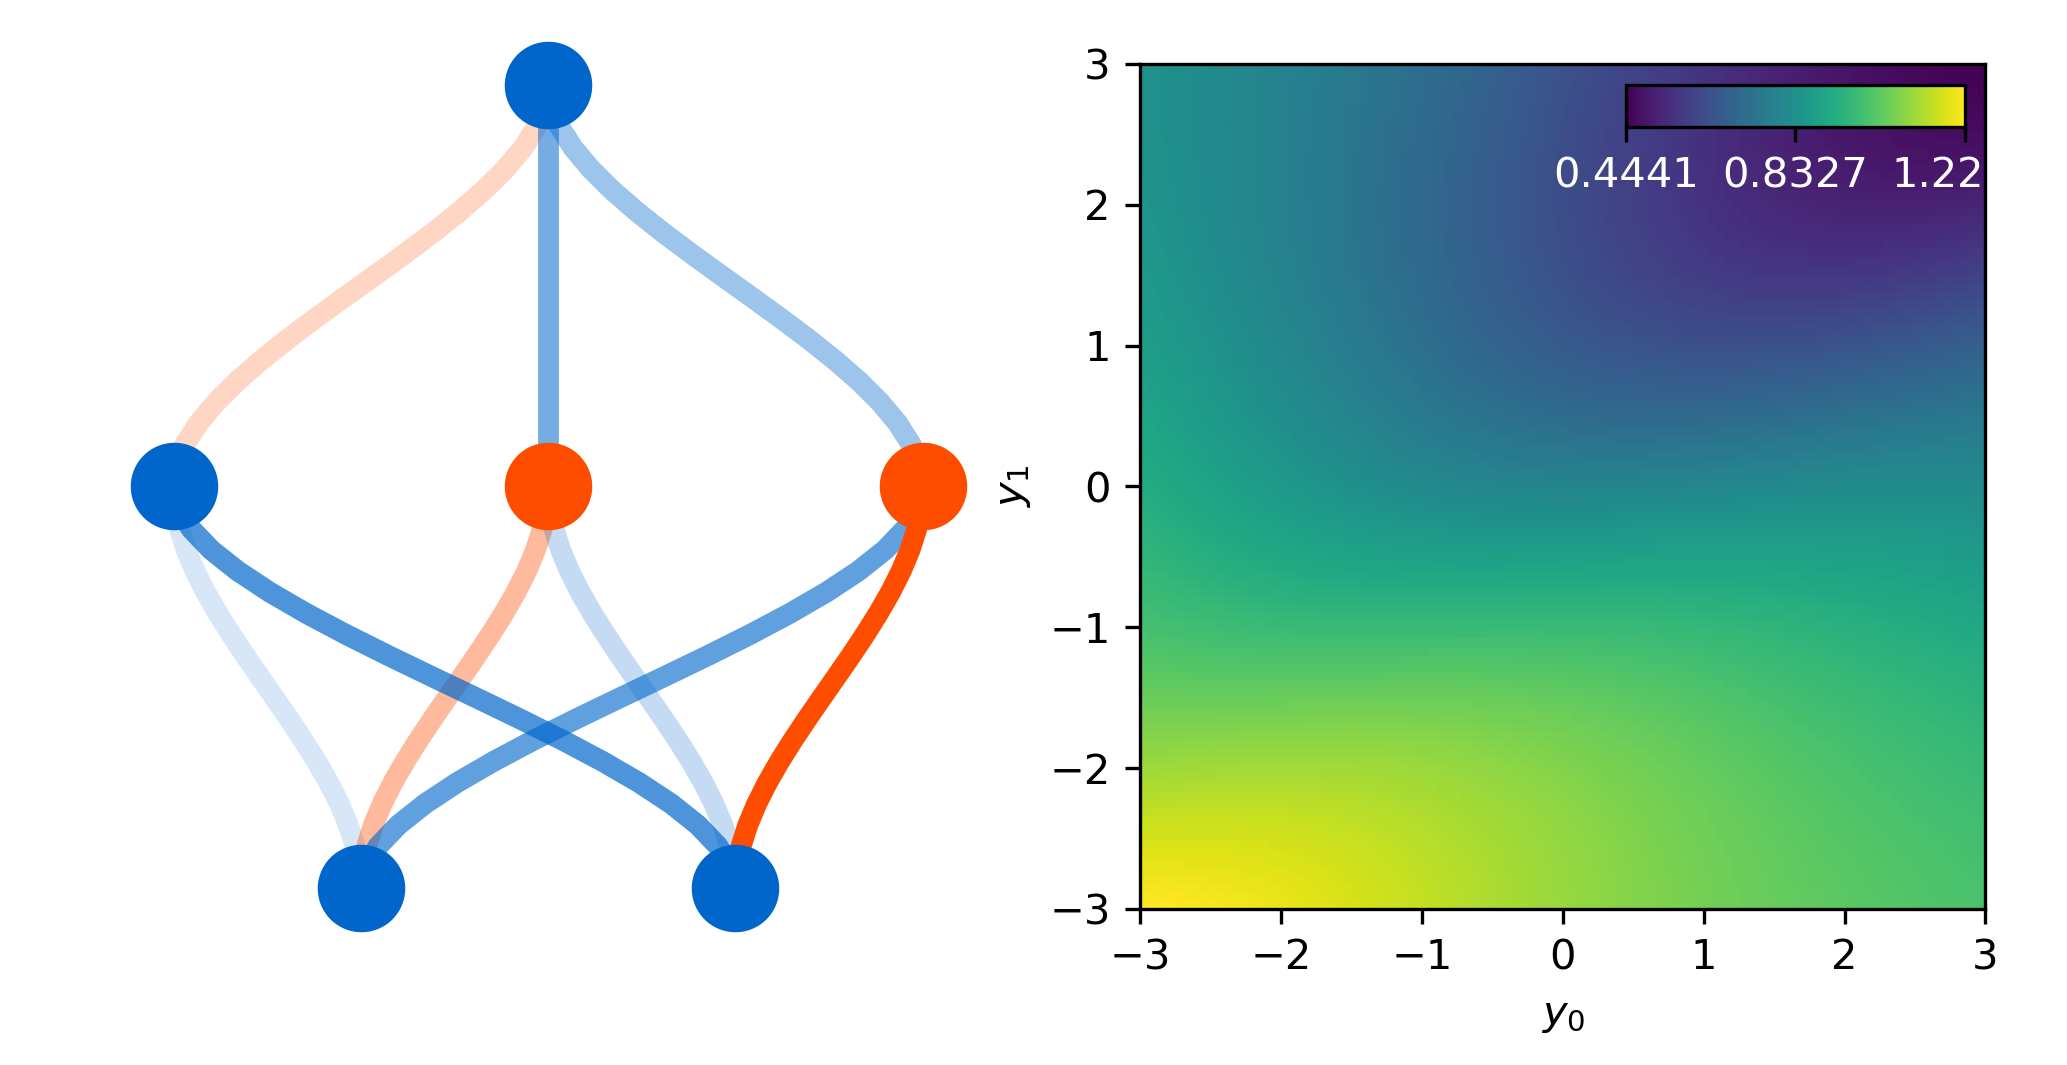

In [8]:
# the same, but with sigmoid (and more compactly written)
visualize_network(weights=[ 
    [ [0.2,0.9],  [-0.5,0.3], [0.8,-1.3]  ],                 
    [ [-0.3,0.7,0.5] ]  
    ],
    biases=[ 
        [0.1,-0.5,-0.5],
        [0.5]
    ],
    activations=[ 'sigmoid', # activation for hidden
                'linear' # activation for output
                ],
    y0range=[-3,3],y1range=[-3,3])

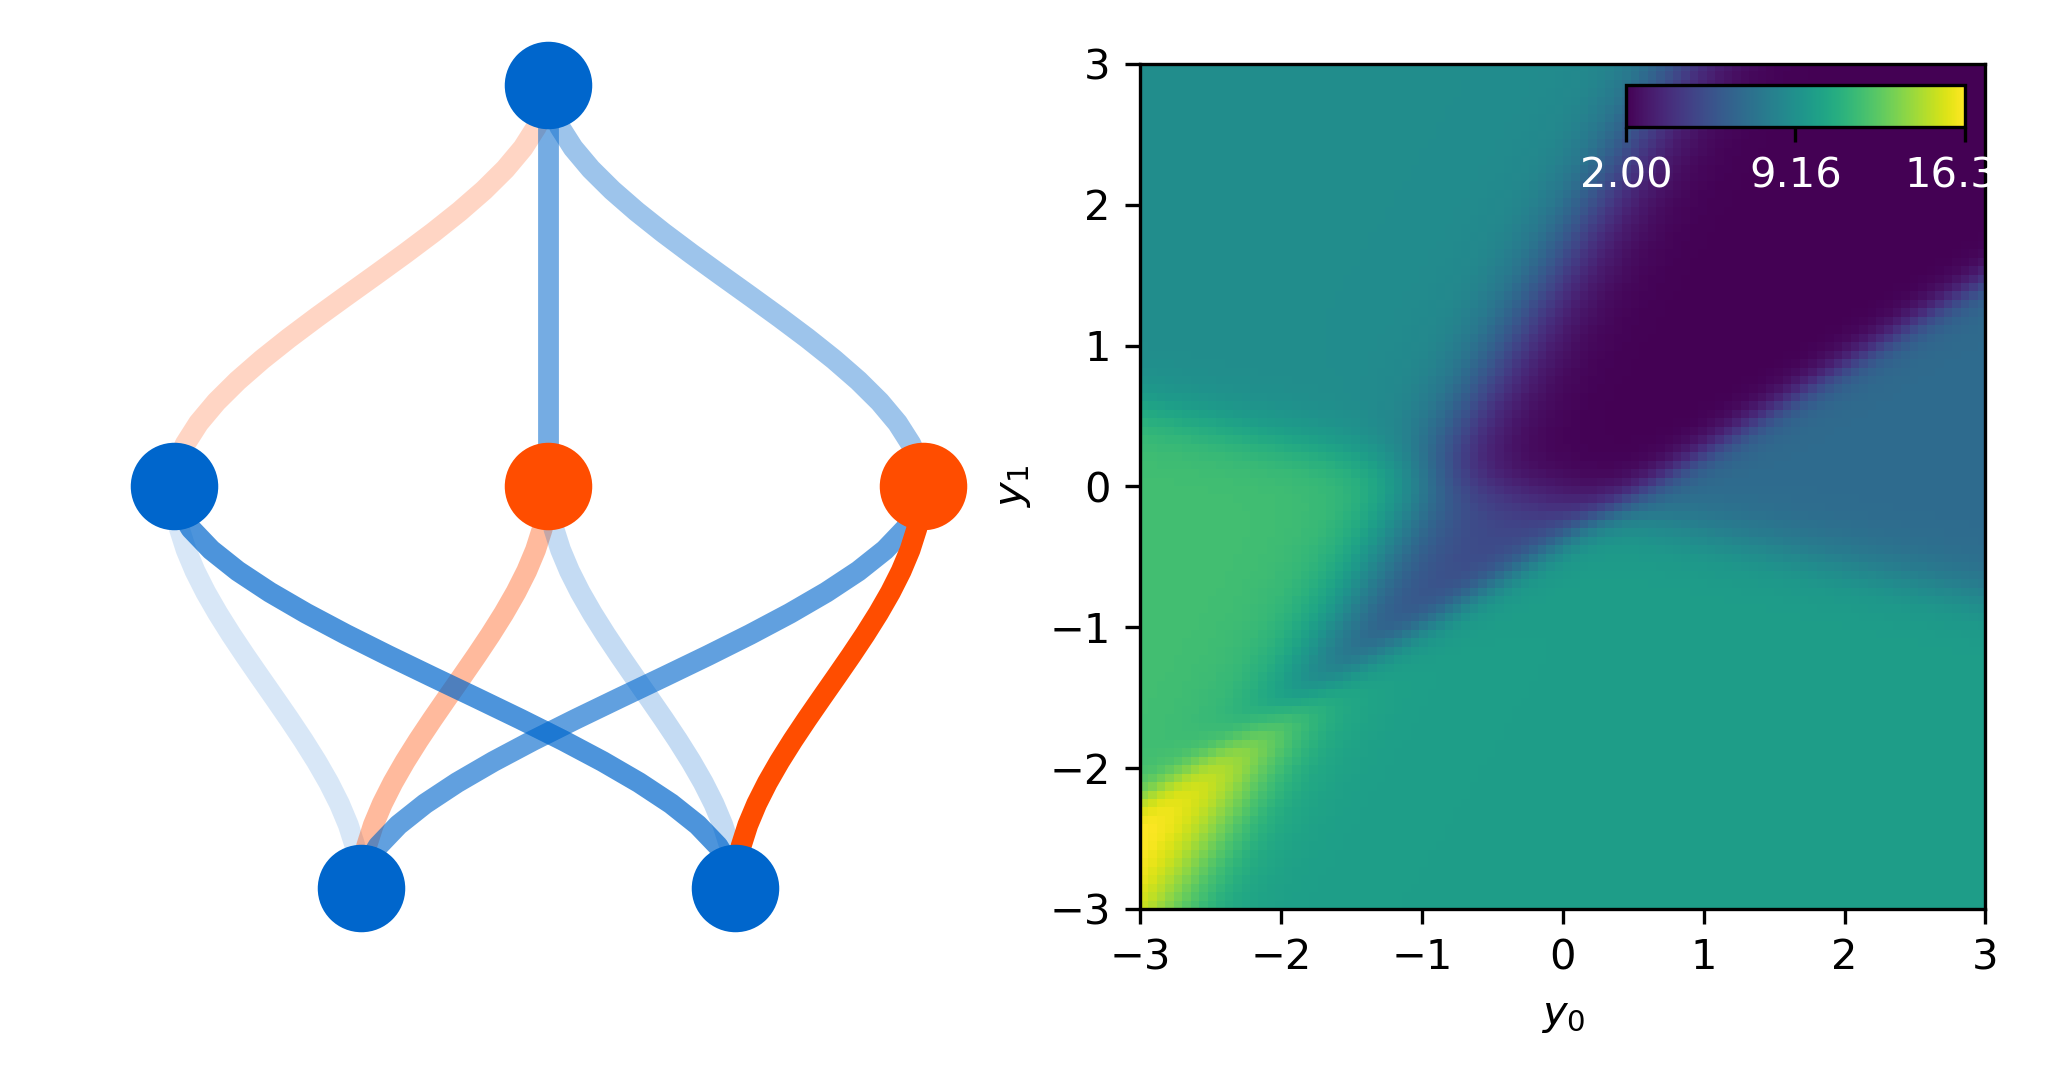

In [9]:
# sharper sigmoid: scale all weights and biases!
factor=10.0
# this needs np.array(), because you cannot do factor*<python-list>

visualize_network(weights=[ 
    factor*np.array([ [0.2,0.9],  [-0.5,0.3], [0.8,-1.3]  ]),                 
    factor*np.array([ [-0.3,0.7,0.5] ])
    ],
    biases=[ 
        factor*np.array([0.1,-0.5,-0.5]),
        factor*np.array([0.5])
    ],
    activations=[ 'sigmoid', # activation for hidden
                'linear' # activation for output
                ],
    y0range=[-3,3],y1range=[-3,3])

## Further examples

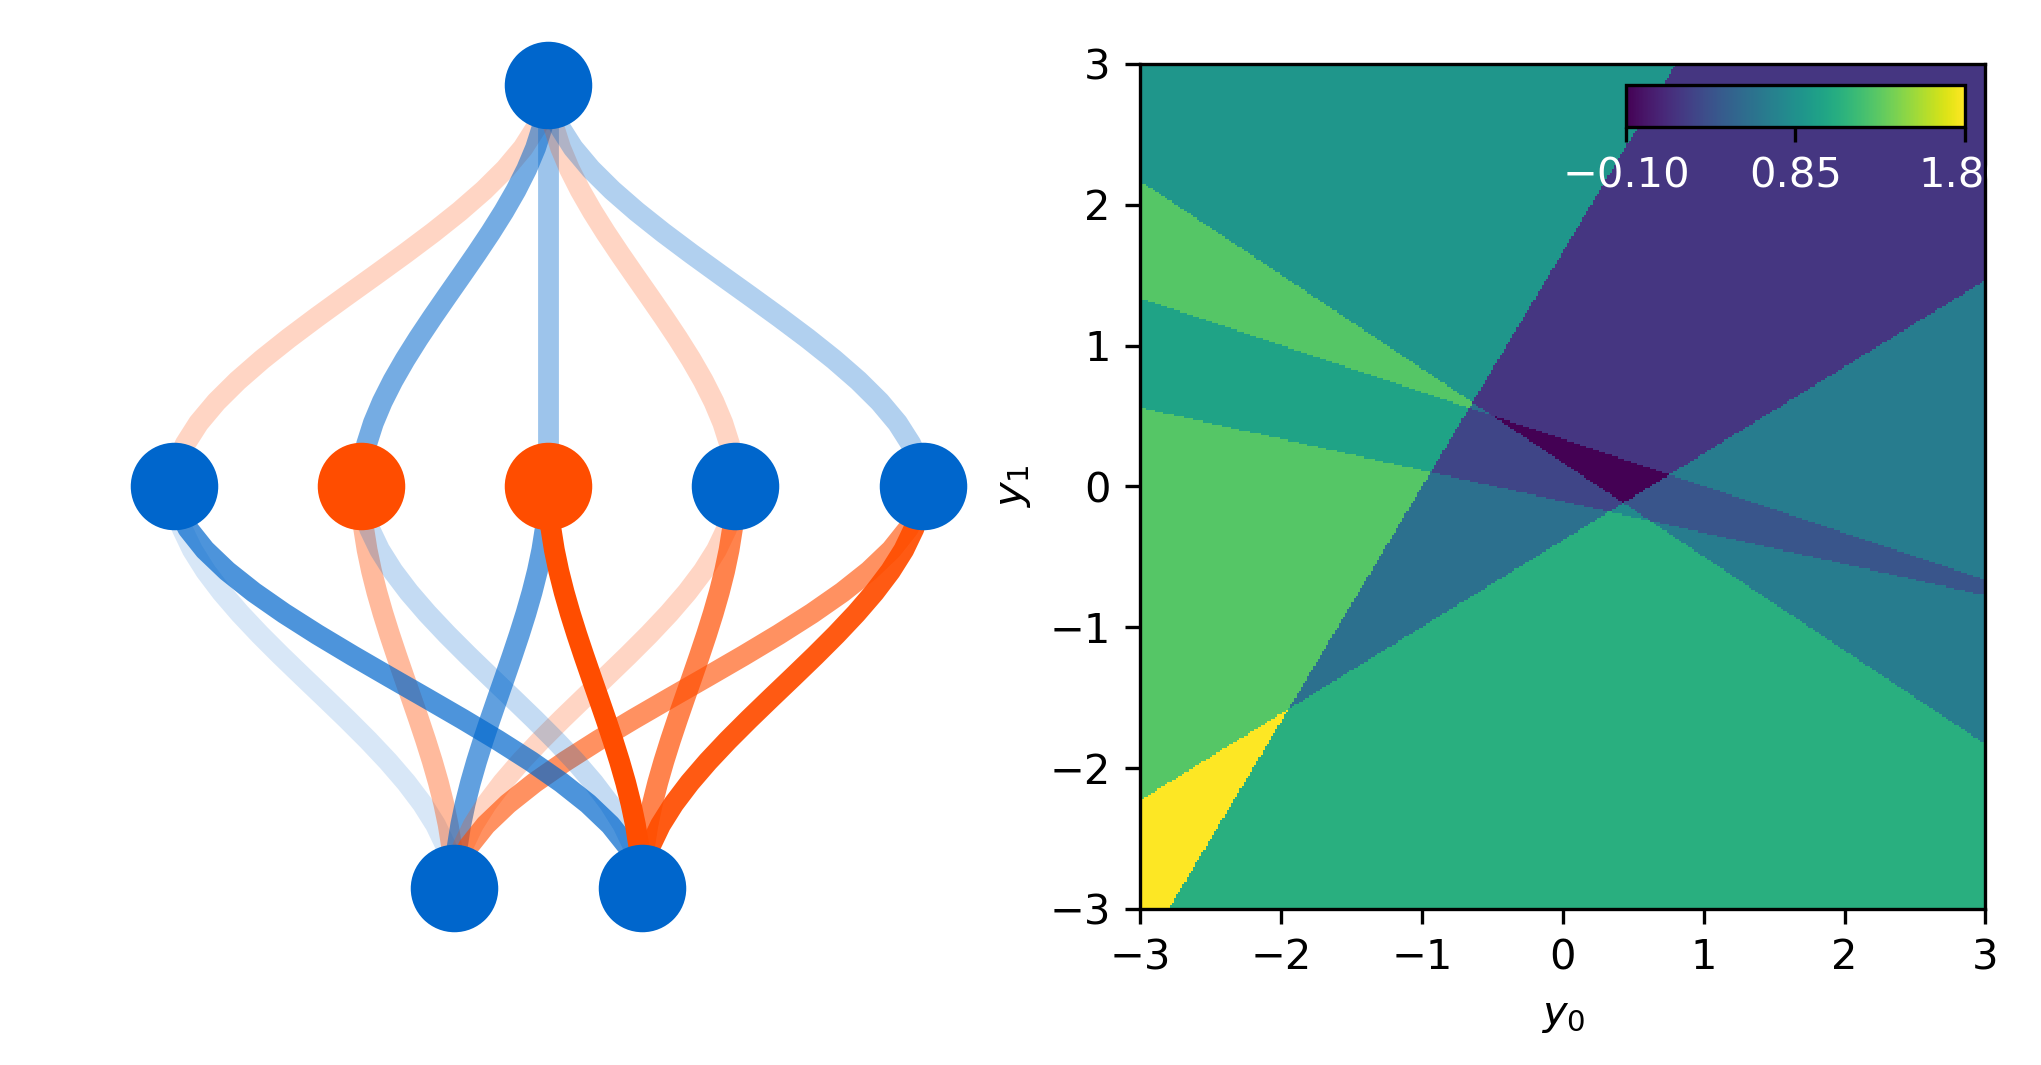

In [10]:
# now with 5 intermediate neurons, for fun:

visualize_network(weights=[ [ [0.2,0.9],[-0.5,0.3],[0.8,-1.3],
                            [-0.3,-0.9], [-0.8,-1.2] ], 
                           [ [-0.3,0.7,0.5,-0.3,0.4] ]  ],
                 biases=[ [0.1,-0.5,-0.5,0.3,0.2], [0.5] ],
                 activations=[ 'jump', 'linear' ],
                 y0range=[-3,3],y1range=[-3,3], M=400)

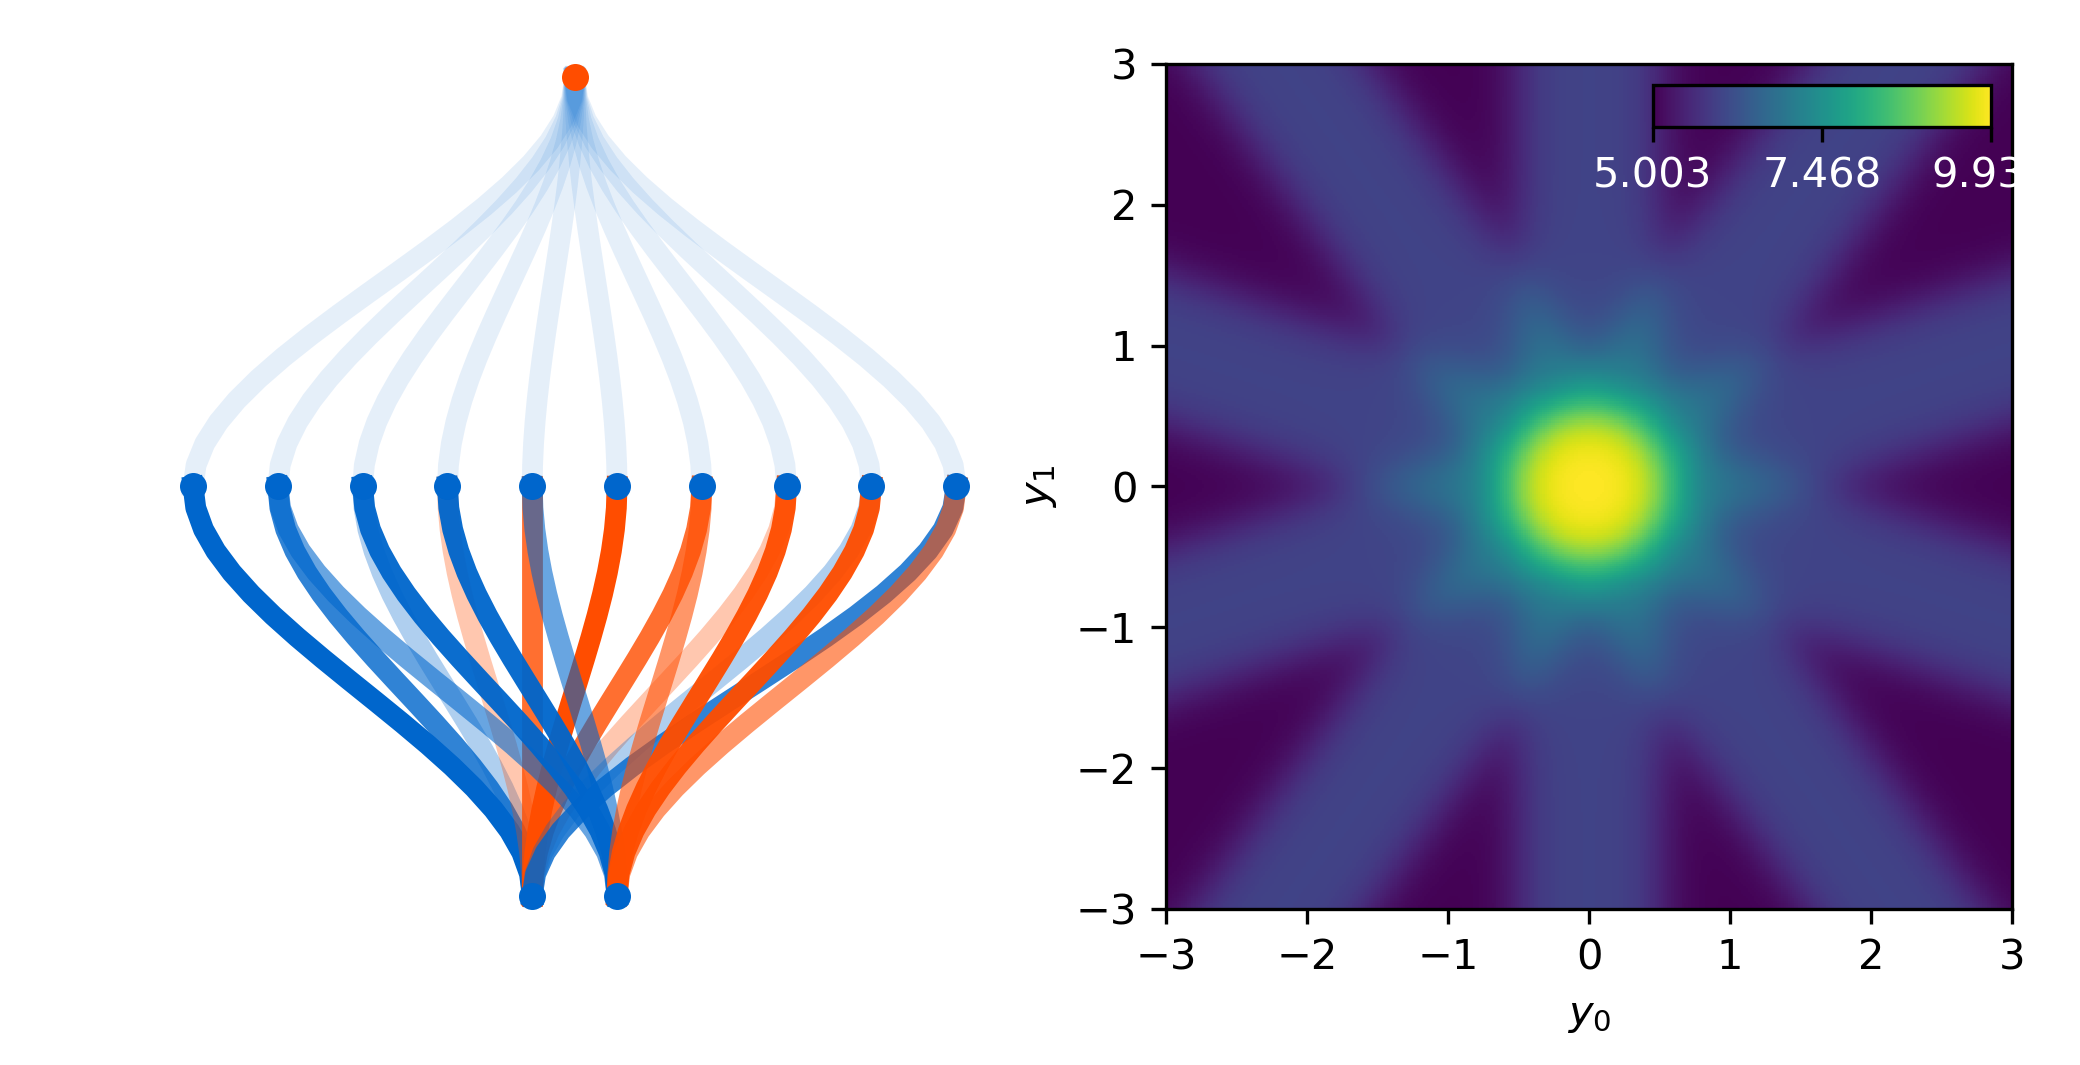

In [11]:
# many superimposed lines
# this can be used to construct arbitrary shapes
# with only a single hidden layer

n_lines=10
phi=np.linspace(0,2*np.pi,n_lines+1)[0:n_lines]

weight_array=np.zeros([n_lines,2])
weight_array[:,0]=factor*np.cos(phi)
weight_array[:,1]=factor*np.sin(phi)
bias_array=np.full(n_lines,factor*(+0.5))

# sharper sigmoid: scale all weights and biases!
factor=20.0
# this needs np.array(), because you cannot do factor*<python-list>
visualize_network(weights=[ 
    weight_array, 
    np.full([1,n_lines],1.0)
    ],
    biases=[ 
        bias_array,
        [0.0]
    ],
    activations=[ 'sigmoid', # activation for hidden
                'linear' # activation for output
                ],
    y0range=[-3,3],y1range=[-3,3],
                 size=30.0,M=400)

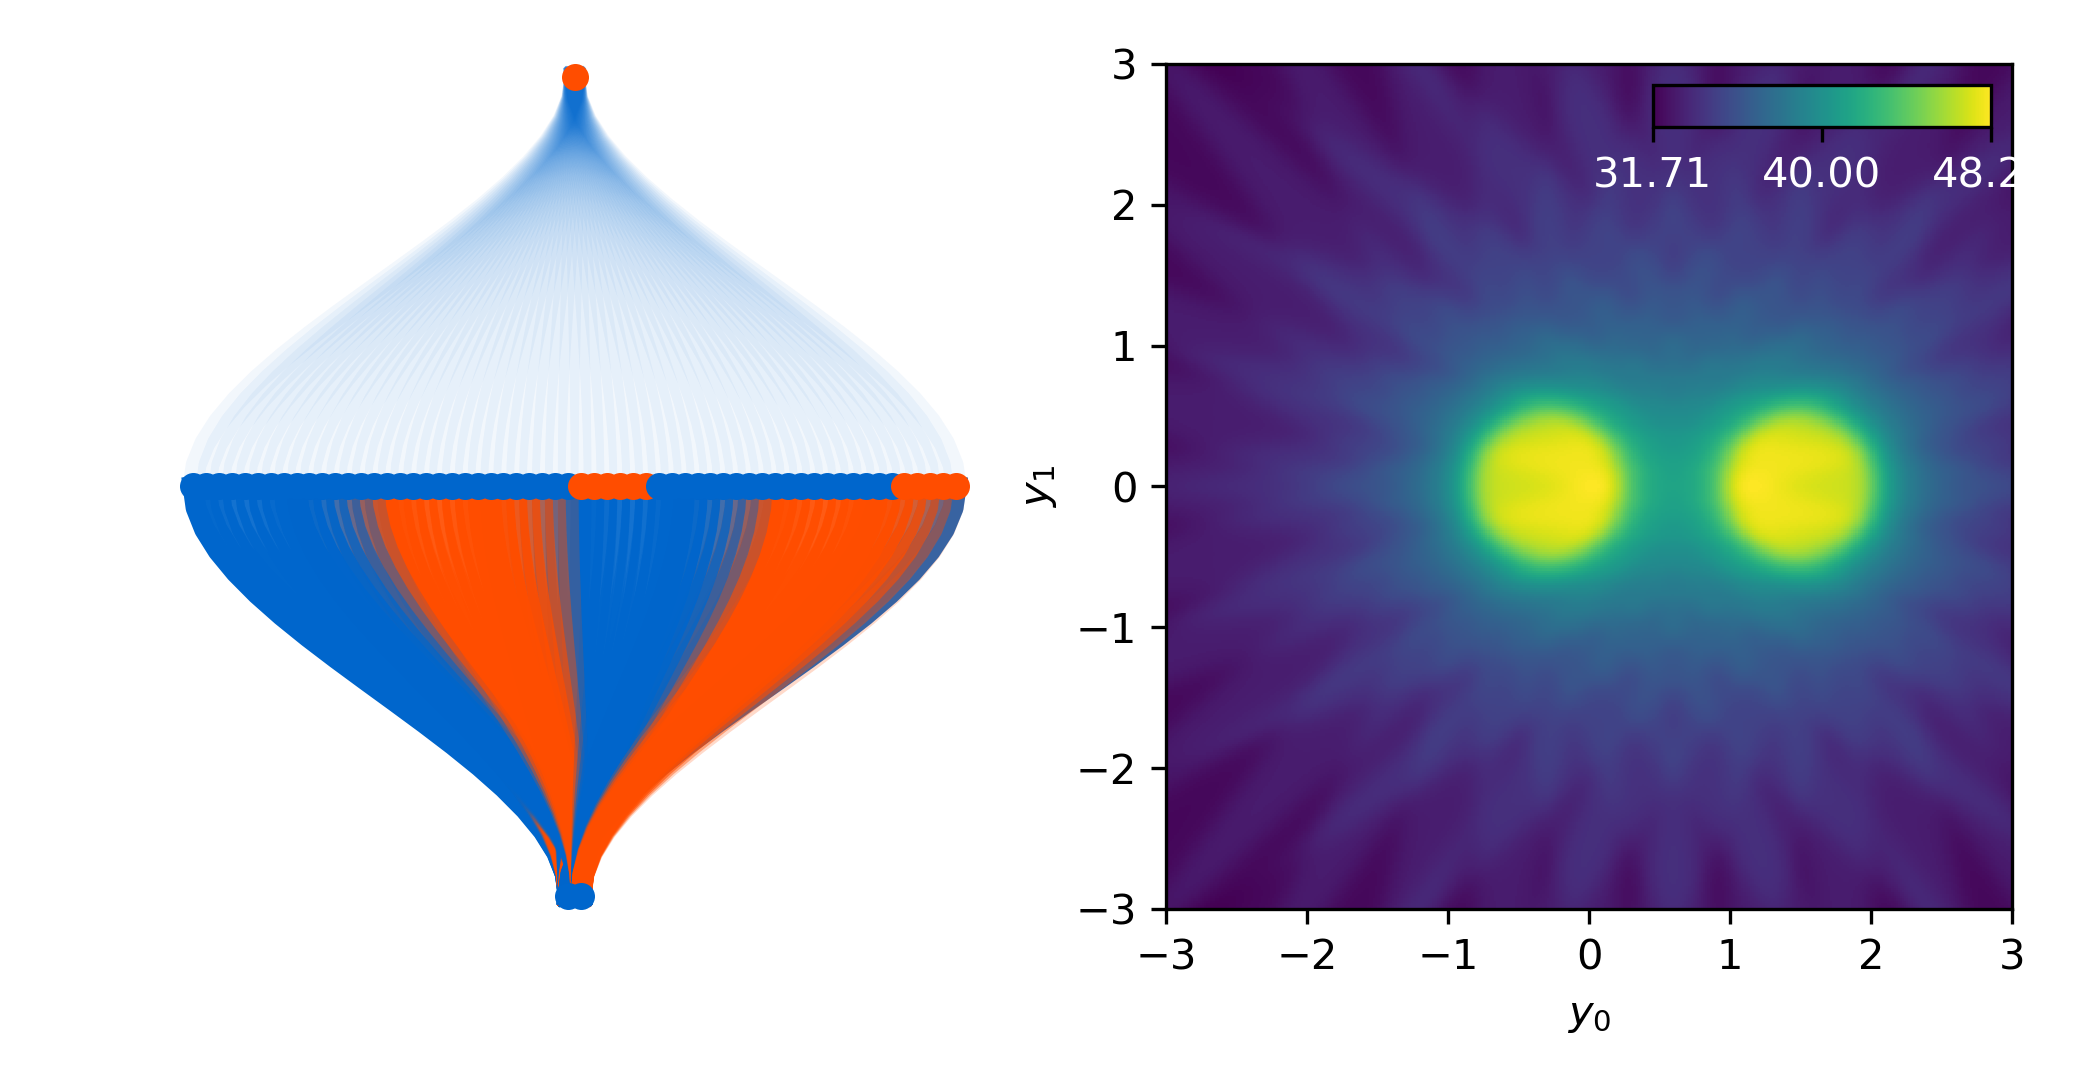

In [12]:
# two blobs, each constructed using many superimposed lines
# this can be used to construct arbitrary shapes
# with only a single hidden layer

n_lines=30
phi=np.linspace(0,2*np.pi,n_lines+1)[0:n_lines]

shifts=[-0.3,1.5]
n_blobs=len(shifts)
full_weight_array=np.zeros([n_blobs*n_lines,2])
full_bias_array=np.zeros(n_blobs*n_lines)

j=0
for shift in shifts:
    weight_array=np.zeros([n_lines,2])
    weight_array[:,0]=factor*np.cos(phi)
    weight_array[:,1]=factor*np.sin(phi)
    bias_array=np.full(n_lines,factor*(+0.5-shift*np.cos(phi)))
    full_weight_array[j*n_lines:(j+1)*n_lines,:]=weight_array[:,:]
    full_bias_array[j*n_lines:(j+1)*n_lines]=bias_array[:]
    j+=1

# sharper sigmoid: scale all weights and biases!
factor=20.0
# this needs np.array(), because you cannot do factor*<python-list>
visualize_network(weights=[ 
    full_weight_array, 
    np.full([1,n_blobs*n_lines],1.0)
    ],
    biases=[ 
        full_bias_array,
        [0.0]
    ],
    activations=[ 'sigmoid', # activation for hidden
                'linear' # activation for output
                ],
    y0range=[-3,3],y1range=[-3,3],
                 size=30.0,M=400)

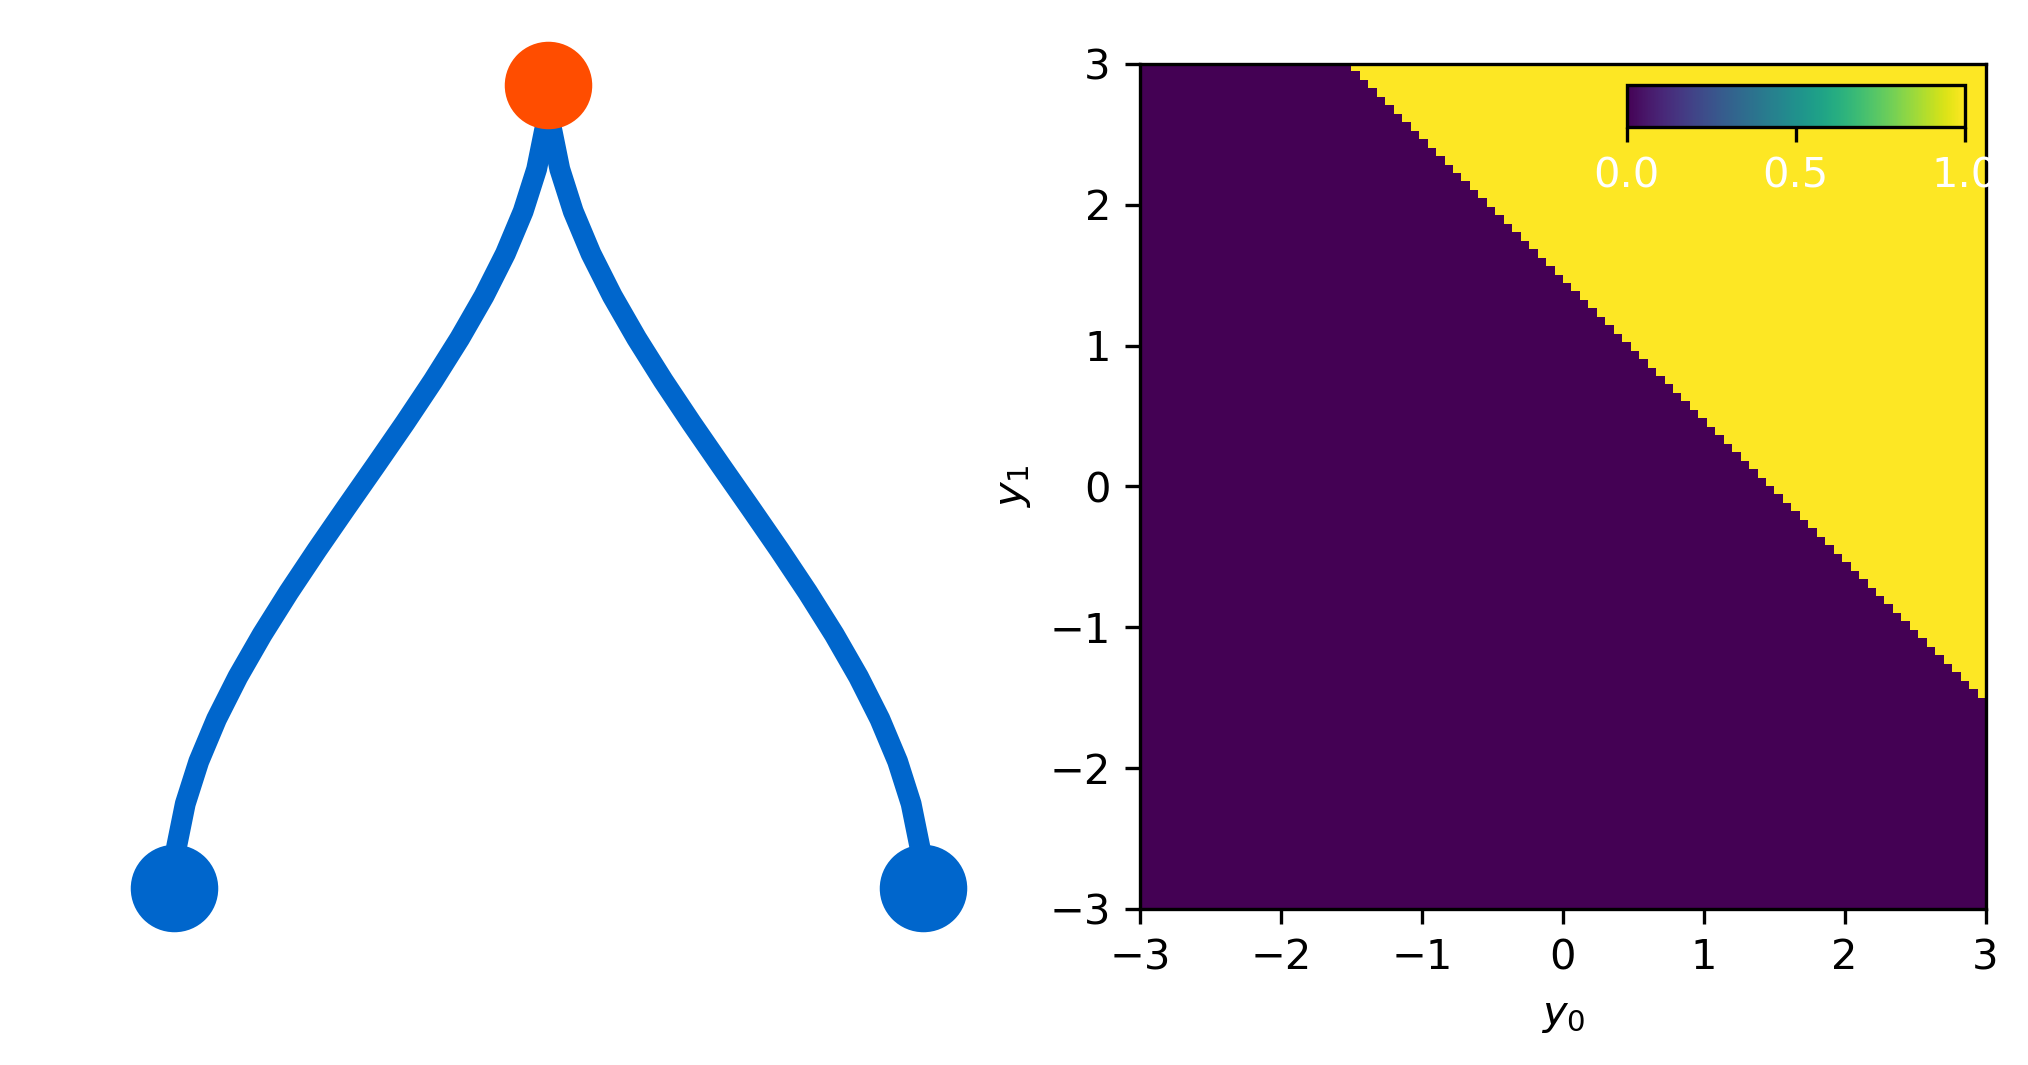

In [10]:
# the AND function
# this computes the AND function of the inputs,
# in the sense that y1=+1,y2=+1 maps to +1, but
# the other combinations (like y1=0,y2=+1 etc.) all map to 0

visualize_network(weights=[ [ 
    [1.0,1.0]  # weights of 2 input neurons for single output neuron
    ] ],
    biases=[ 
        [-1.5] # bias for single output neuron
            ],
    activations=[ 'jump' # activation for output
                ],
    y0range=[-3,3],y1range=[-3,3])